# GP Analysis: Based on Residuals 



In [1]:
import os 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy 
import scipy.stats as stats
from scipy.stats import sem 
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
from sklearn.linear_model import LinearRegression
import json
import copy

## Load discrimination data

In [2]:
_dir = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_discrimination'
# _dir = '/Users/pmahableshwarkar/Documents/Depth_Project/depth_discrimination'
# raw_dir = _dir + '/data/finalVEMatched/raw/'
zs_dir = _dir + '/data/finalDiscrimMatched/z_scored_RT/'

# final_data = pd.read_csv (raw_dir + '/raw_discrim.csv')
zscored_data = pd.read_csv (zs_dir + 'final_discrim.csv')

In [3]:
p = _dir + '/data/finalDiscrimMatched/performance.pkl'
unpickled_df = pd.read_pickle(p) 
len(unpickled_df)

156

In [10]:
stimuli_path = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_duration_stimuli'
kinect192_path = '/Users/prachimahableshwarkar/Documents/GW/SUNRGBD/updated/kinect2data_192'

# stimuli_path = '/Users/pmahableshwarkar/Documents/Depth_Project/final_stimuli'
# kinect192_path = '/Users/pmahableshwarkar/Documents/Depth_Project/SUNRGBD/kinect2data_192'

targetDepths = {}

for stim in os.listdir(stimuli_path):
    if 'resize' in stim:
        p = stimuli_path + '/' + stim + '/data.json'
        data = json.load(open(p))
        target_depth = data['objects'][0]['crossing_point'][0]['depth']
        target_object = data['objects'][0]['name']
        targetDepths[stim[:-2]] = target_depth

## Load Ground Plane Metrics: Pixel SA

In [12]:
# path = '/Users/pmahableshwarkar/Documents/Depth_Project/SUN_scene_cue_coding/VGP_size_dict.json'
path = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/SUN_scene_cue_coding/VGP_size_dict.json'

vgp_size_dict = json.load(open(path))



In [5]:
# path = '/Users/pmahableshwarkar/Documents/Depth_Project/SUN_scene_cue_coding/GP_size_dict.json'
path = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/SUN_scene_cue_coding/GP_size_dict.json'

gp_size_dict = json.load(open(path))

In [14]:
VGPS = []
GPS = []
TDS = []
for key in vgp_size_dict:
    try:
        gp = gp_size_dict[key]
        VGPS.append(vgp_size_dict[key])
        GPS.append(gp)
        TDS.append(targetDepths[key])
    except:
        pass

print(stats.pearsonr(VGPS, GPS))
print(stats.pearsonr(VGPS, TDS))
print(stats.pearsonr(GPS, TDS))

(0.6305436407876517, 4.100796404472425e-18)
(0.1465931961258253, 0.07247634775275881)
(0.2664505181464459, 0.0009430642237052936)


In [7]:
# Find GP Outliers 

gpsize_list = [[key, gp_size_dict[key]] for key in gp_size_dict]
gpsize_mean = np.mean(np.array([elem[1] for elem in gpsize_list]))
gpsize_std = np.std(np.array([elem[1] for elem in gpsize_list]))

gpsize_outlierRange = [gpsize_mean - (3*gpsize_std), gpsize_mean + (3*gpsize_std)]

cleaned_gpsize_dict = {}
for key in gp_size_dict:
    if gpsize_outlierRange[0] < gp_size_dict[key] < gpsize_outlierRange[1]:
        cleaned_gpsize_dict[key] = gp_size_dict[key]
    else:
        print(key, 'excluded')

002118_2014-06-25_20-32-08_260595134347_rgbf000078-resize excluded
002657_2014-06-13_15-29-54_094959634447_rgbf000150-resize excluded


In [8]:
# Find VGP Outliers 

vgpsize_list = [[key, vgp_size_dict[key]] for key in vgp_size_dict]
vgpsize_mean = np.mean(np.array([elem[1] for elem in vgpsize_list]))
vgpsize_std = np.std(np.array([elem[1] for elem in vgpsize_list]))

vgpsize_outlierRange = [vgpsize_mean - (3*vgpsize_std), vgpsize_mean + (3*vgpsize_std)]

cleaned_vgpsize_dict = {}
for key in vgp_size_dict:
    if vgpsize_outlierRange[0] < vgp_size_dict[key] < vgpsize_outlierRange[1]:
        cleaned_vgpsize_dict[key] = vgp_size_dict[key]
    else:
        print(key, 'excluded')

002568_2014-06-24_13-59-21_094959634447_rgbf000062-resize excluded
002600_2014-06-24_14-27-04_094959634447_rgbf000074-resize excluded
002118_2014-06-25_20-32-08_260595134347_rgbf000078-resize excluded
002570_2014-06-24_13-59-54_094959634447_rgbf000059-resize excluded


In [15]:
folders = [f.split('/')[1][:-2] for f in list(unpickled_df.keys())]
folders[0], list(unpickled_df.keys())[0]

('000483_2014-06-09_20-41-45_260595134347_rgbf000116-resize',
 'depth_discrimination_stimuli/000483_2014-06-09_20-41-45_260595134347_rgbf000116-resize_4/000483_2014-06-09_20-41-45_260595134347_rgbf000116-resize_4-target.png')

In [18]:
ordered_gp_size = []
ordered_vgp_size = []
ordered_tds_gp = []
ordered_tds_vgp = []

gp_none = 0
vgp_none = 0
for folder in folders:
    try:
        ordered_gp_size.append(cleaned_gpsize_dict[folder])
        ordered_tds_gp.append(targetDepths[folder])
    except:
        gp_none += 1
        ordered_gp_size.append(None)
        ordered_tds_gp.append(None)

    try:
        ordered_vgp_size.append(cleaned_vgpsize_dict[folder])
        ordered_tds_vgp.append(targetDepths[folder])
    except:
        vgp_none += 1
        ordered_vgp_size.append(None)
        ordered_tds_vgp.append(None)


In [20]:
len(ordered_gp_size), len(ordered_tds_gp), len(ordered_vgp_size), len(ordered_tds_vgp)

(156, 156, 156, 156)

## Linear Model: GP x Target Depth

In [29]:
gpvals = [elem for elem in ordered_gp_size if elem != None]
gp_tdvals = [elem for elem in ordered_tds_gp if elem != None]

m: [2.53282356]
b: 10.458699577467081
R-squared:  0.0659683158968628
Corr, p-val (0.2568429790686581, 0.0015669902616939355)


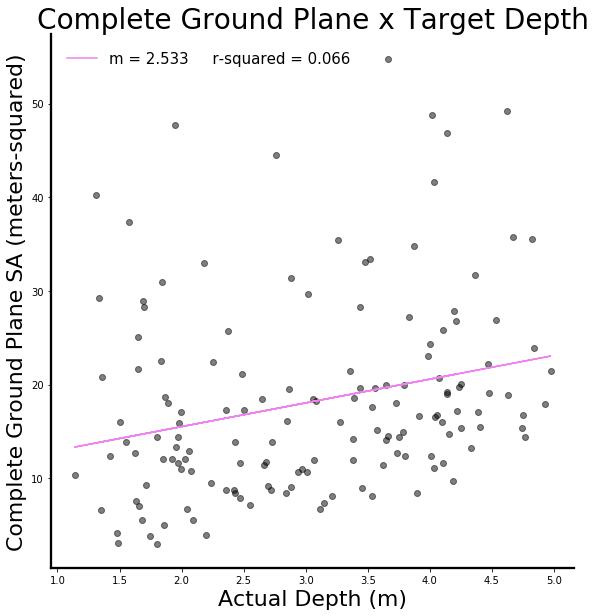

In [30]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[8,8])
plt.tight_layout()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
#run regression
X = np.array(gp_tdvals).reshape(-1,1)
y = gpvals
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);
plt.plot(X,y_predicted,color='violet', label = 'm = ' + str(round(reg.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg.score(X, y)), 3)))
plt.title("Complete Ground Plane x Target Depth", fontsize = 28)
plt.xlabel("Actual Depth (m)", fontsize = 22)
plt.ylabel("Complete Ground Plane SA (meters-squared)", fontsize = 22)

# plt.xticks(np.arange(1, 6, 1), fontsize=15)
# plt.yticks(np.arange(-1,1.5, 0.5), fontsize=15)
# plt.ylim(-1.5,1.5)

legend = plt.legend(loc = 0, fontsize = 15, borderpad = 0.6, labelspacing = 1, frameon=False)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))
print("Corr, p-val", stats.pearsonr(gpvals, gp_tdvals))

gpTD_residuals = copy.deepcopy(y - y_predicted)

## Linear Model: GP x Target Depth

In [31]:
vgpvals = [elem for elem in ordered_vgp_size if elem != None]
vgp_tdvals = [elem for elem in ordered_tds_vgp if elem != None]

m: [0.82143443]
b: 5.1356107862326335
R-squared:  0.03337779577523614
Corr, p-val (0.18269591066916657, 0.026771329251583455)


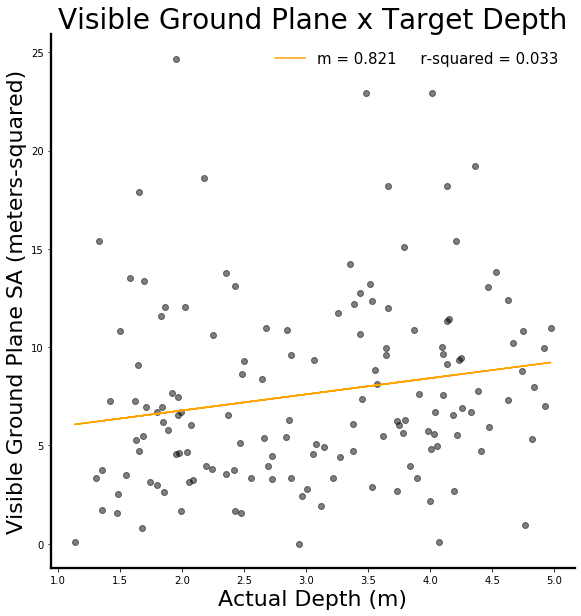

In [32]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[8,8])
plt.tight_layout()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
#run regression
X = np.array(vgp_tdvals).reshape(-1,1)
y = vgpvals
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);
plt.plot(X,y_predicted,color='orange', label = 'm = ' + str(round(reg.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg.score(X, y)), 3)))
plt.title("Visible Ground Plane x Target Depth", fontsize = 28)
plt.xlabel("Actual Depth (m)", fontsize = 22)
plt.ylabel("Visible Ground Plane SA (meters-squared)", fontsize = 22)

# plt.xticks(np.arange(1, 6, 1), fontsize=15)
# plt.yticks(np.arange(-1,1.5, 0.5), fontsize=15)
# plt.ylim(-1.5,1.5)

legend = plt.legend(loc = 0, fontsize = 15, borderpad = 0.6, labelspacing = 1, frameon=False)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))
print("Corr, p-val", stats.pearsonr(vgpvals, vgp_tdvals))

vgpTD_residuals = copy.deepcopy(y - y_predicted)

## Discrimination Residuals: PC x Kinect Coded Depth Difference

In [33]:
p = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_discrimination/data/finalDiscrimMatched/kinectCoded_discrimination/'

dresiduals_125 = np.load(p + 'residuals_125.npy')
dresiduals_250 = np.load(p + 'residuals_250.npy')
dresiduals_1000 = np.load(p + 'residuals_1000.npy')

dstim = np.load(p + 'final_stim.npy')

dstim_folders = [f.split('/')[1][:-2] for f in dstim]


In [38]:
trunc_vgpTDResid = []
trunc_gpTDResid = []

vgp_trunc_dresiduals_125 = []
vgp_trunc_dresiduals_250 = []
vgp_trunc_dresiduals_1000 = []

gp_trunc_dresiduals_125 = []
gp_trunc_dresiduals_250 = []
gp_trunc_dresiduals_1000 = []

i = 0
for elem in cleaned_gpsize_dict:
    try:
        dstim_i = dstim_folders.index(elem)
        gp_trunc_dresiduals_125.append(dresiduals_125[dstim_i])
        gp_trunc_dresiduals_250.append(dresiduals_250[dstim_i])
        gp_trunc_dresiduals_1000.append(dresiduals_1000[dstim_i])
        
        trunc_gpTDResid.append(gpTD_residuals[i])


    except:
        pass
    i += 1

j = 0
for elem in cleaned_vgpsize_dict:
    try:
        dstim_i = dstim_folders.index(elem)
        vgp_trunc_dresiduals_125.append(dresiduals_125[dstim_i])
        vgp_trunc_dresiduals_250.append(dresiduals_250[dstim_i])
        vgp_trunc_dresiduals_1000.append(dresiduals_1000[dstim_i])
        
        trunc_vgpTDResid.append(vgpTD_residuals[j])


    except:
        pass
    j += 1
    
len(trunc_vgpTDResid), len(vgp_trunc_dresiduals_125), len(trunc_gpTDResid), len(gp_trunc_dresiduals_125)


(147, 147, 149, 149)

## Correlation 

In [39]:
gp_trunc_dresiduals_avg = np.mean([np.array(gp_trunc_dresiduals_125), np.array(gp_trunc_dresiduals_250), np.array(gp_trunc_dresiduals_1000)], axis =0)


In [43]:
print('Correlation between residuals (discrim PC x kinect diff) and residuals (GP x target depth)')
print('125 ms: ',stats.pearsonr(gp_trunc_dresiduals_125, trunc_gpTDResid))
print('250 ms: ',stats.pearsonr(gp_trunc_dresiduals_250, trunc_gpTDResid))
print('1000 ms: ',stats.pearsonr(gp_trunc_dresiduals_1000, trunc_gpTDResid))

print('Avg: ',stats.pearsonr(gp_trunc_dresiduals_avg, trunc_gpTDResid))

print('All: ',stats.pearsonr(gp_trunc_dresiduals_125 + gp_trunc_dresiduals_250 + gp_trunc_dresiduals_1000, trunc_gpTDResid*3))


Correlation between residuals (discrim PC x kinect diff) and residuals (GP x target depth)
125 ms:  (-0.06255496612886807, 0.4485152784458977)
250 ms:  (-0.04960343897331962, 0.5480012989002233)
1000 ms:  (-0.01203503807566032, 0.8841784200626227)
Avg:  (-0.040877970468727626, 0.6206114960773624)
All:  (-0.03978955853434721, 0.4013443960763409)


In [44]:
vgp_trunc_dresiduals_avg = np.mean([np.array(vgp_trunc_dresiduals_125), np.array(vgp_trunc_dresiduals_250), np.array(vgp_trunc_dresiduals_1000)], axis =0)


In [45]:
print('Correlation between residuals (discrim PC x kinect diff) and residuals (VGP x target depth)')
print('125 ms: ',stats.pearsonr(vgp_trunc_dresiduals_125, trunc_vgpTDResid))
print('250 ms: ',stats.pearsonr(vgp_trunc_dresiduals_250, trunc_vgpTDResid))
print('1000 ms: ',stats.pearsonr(vgp_trunc_dresiduals_1000, trunc_vgpTDResid))

print('Avg: ',stats.pearsonr(vgp_trunc_dresiduals_avg, trunc_vgpTDResid))

print('All: ',stats.pearsonr(vgp_trunc_dresiduals_125 + vgp_trunc_dresiduals_250 + vgp_trunc_dresiduals_1000, trunc_vgpTDResid*3))


Correlation between residuals (discrim PC x kinect diff) and residuals (VGP x target depth)
125 ms:  (-0.08366044481029332, 0.3137247344046776)
250 ms:  (-0.07764769306216955, 0.3498894776593516)
1000 ms:  (-0.1062654247168783, 0.20018263702476546)
Avg:  (-0.0920746443274239, 0.2673552888568339)
All:  (-0.08964551560995812, 0.05997171355795576)
